In [2]:
from src.vrp.utils.getData import GetData
from src.vrp.algorithm.population import Population
from src.vrp.algorithm.genetic import Genetic
from src.vrp.utils.utils import *

import random
import numpy as np

random.seed(42)
np.random.seed(42)

## Cấu hình tham số

In [3]:
DEPOT = "University of Transport and Communications"
NUM_POINTS = 40
MAX_DISTANCE = 15
NUM_VEHICLES = 5

# GA parameters
POPULATION_SIZE = 500
MAX_GENERATIONS = 1000
MUTATION_RATE = 0.01
ELITISM_SIZE = 5

## Hiển thị dữ liệu trên Map

In [4]:
data_generator = GetData(
        location_name=DEPOT, 
        num_random_points=NUM_POINTS,  
        max_distance_km=MAX_DISTANCE
)

locations, distance_matrix = data_generator.run()

In [5]:
map_center = create_map_with_markers(locations, DEPOT)
map_center

## Ma trận khoảng cách giữa các điểm

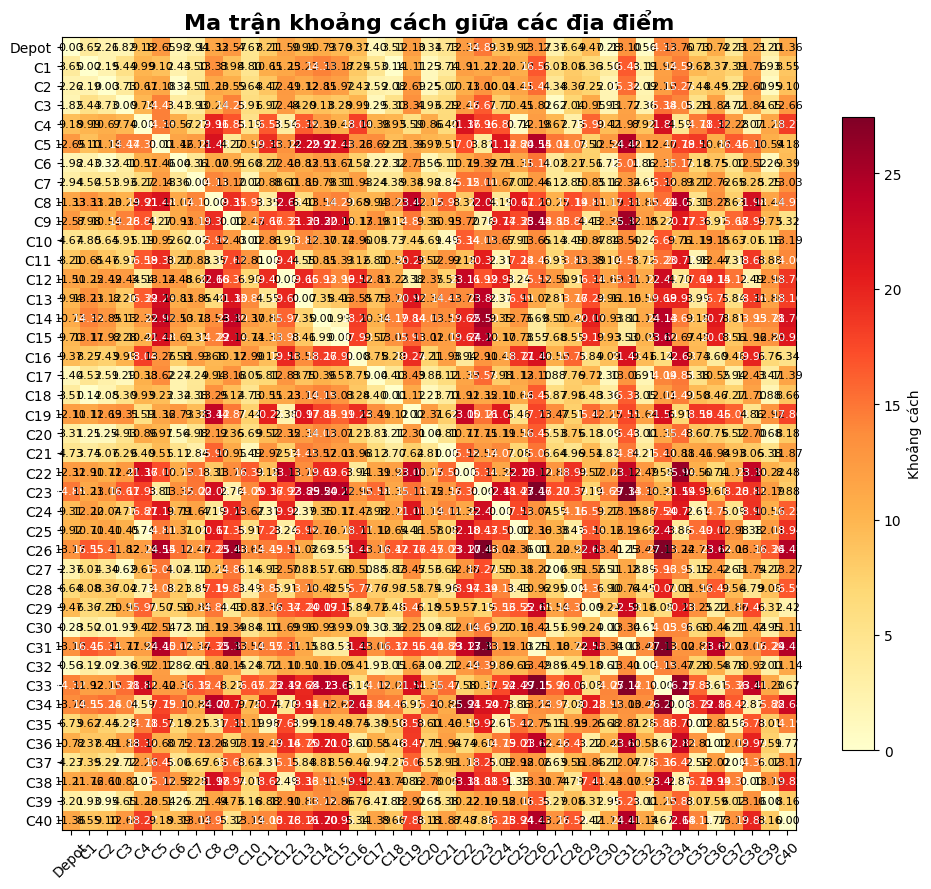

In [ ]:
# Convert the distance matrix to a numpy array if it's not already
distance_array = np.array(distance_matrix)

# Create location labels - assuming these are positions 0 to NUM_POINTS
location_labels = ["Depot"] + [f"C{i}" for i in range(1, NUM_POINTS + 1)]

fig2, ax = plt.subplots(figsize=(10, 9))

# Display the distance matrix as an image
im = ax.imshow(distance_array, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(distance_array)))
ax.set_yticks(range(len(distance_array)))
ax.set_xticklabels(location_labels, rotation=45, fontsize=10)
ax.set_yticklabels(location_labels, fontsize=10)

# Add values to each cell
for i in range(len(distance_array)):
    for j in range(len(distance_array)):
        val = distance_array[i, j]
        ax.text(j, i, f'{val:.2f}',
                ha="center", va="center",
                color='white' if val > distance_array.max() / 2 else 'black',
                fontsize=8)

plt.colorbar(im, ax=ax, shrink=0.8, label='Khoảng cách')
ax.set_title('Ma trận khoảng cách giữa các địa điểm', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## Khởi tạo quần thể và khởi tạo lộ trình ban đầu

In [7]:
population = Population(
        pop_size=POPULATION_SIZE,
        num_locations=NUM_POINTS,
        num_vehicles=NUM_VEHICLES,
        distance_matrix=distance_matrix
    )

initial_best = population.find_best_chromosome()

In [8]:
import os
from IPython.display import display, HTML

# Make sure the directory exists
static_dir = "./data/static"
os.makedirs(static_dir, exist_ok=True)

# Create initial map with markers and routes
initial_map = data_generator.create_map()
data_generator.add_markers()
draw_routes(initial_map, locations, initial_best.get_routes())

# Save to file
initial_map_path = os.path.join(static_dir, "initial_solution.html")
initial_map.save(initial_map_path)


# Display the map in the notebook
display(HTML(f'<h3>Initial Solution Map</h3>'))
display(initial_map)

## Chạy giải thuật GA để tìm lộ trình tốt nhất

In [9]:
ga = Genetic(
    population=population,
    max_generations=MAX_GENERATIONS,
    mutation_rate=MUTATION_RATE,
    elitism_size=ELITISM_SIZE
)

final_solution = ga.run(verbose=True)

Starting genetic algorithm with 500 chromosomes
Initial best fitness: 414.97
Generation 10/1000 - Best: 321.36, Avg: 390.05, Time: 0.13s
Generation 20/1000 - Best: 260.52, Avg: 308.91, Time: 0.27s
Generation 30/1000 - Best: 230.84, Avg: 259.95, Time: 0.40s
Generation 40/1000 - Best: 212.74, Avg: 230.33, Time: 0.53s
Generation 50/1000 - Best: 194.81, Avg: 211.38, Time: 0.66s
Generation 60/1000 - Best: 184.51, Avg: 194.04, Time: 0.79s
Generation 70/1000 - Best: 178.69, Avg: 182.87, Time: 0.91s
Generation 80/1000 - Best: 173.57, Avg: 176.66, Time: 1.03s
Generation 90/1000 - Best: 173.15, Avg: 173.89, Time: 1.16s
Generation 100/1000 - Best: 168.85, Avg: 174.23, Time: 1.36s
Generation 110/1000 - Best: 167.43, Avg: 169.20, Time: 1.49s
Generation 120/1000 - Best: 166.70, Avg: 167.65, Time: 1.60s
Generation 130/1000 - Best: 165.84, Avg: 168.13, Time: 1.72s
Generation 140/1000 - Best: 164.68, Avg: 165.85, Time: 1.87s
Generation 150/1000 - Best: 164.61, Avg: 165.01, Time: 1.99s
Generation 160/10

## Kết quả

In [10]:
final_map = data_generator.create_map()
data_generator.add_markers()
draw_routes(final_map, locations, final_solution.get_routes())
final_map_path = os.path.join(static_dir, "final_solution.html")
final_map.save(final_map_path)

display(HTML(f'<h3>Final Solution Map</h3>'))
display(final_map)


C:\Users\rowan.nguyen\AppData\Local\Temp\ipykernel_22036\2974764476.py:75: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rowan.nguyen\AppData\Local\Temp\ipykernel_22036\2974764476.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rowan.nguyen\AppData\Local\Temp\ipykernel_22036\2974764476.py:75: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\rowan.nguyen\do_an_final\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rowan.nguyen\do_an_final\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rowan.nguyen\do_an_final\.ve

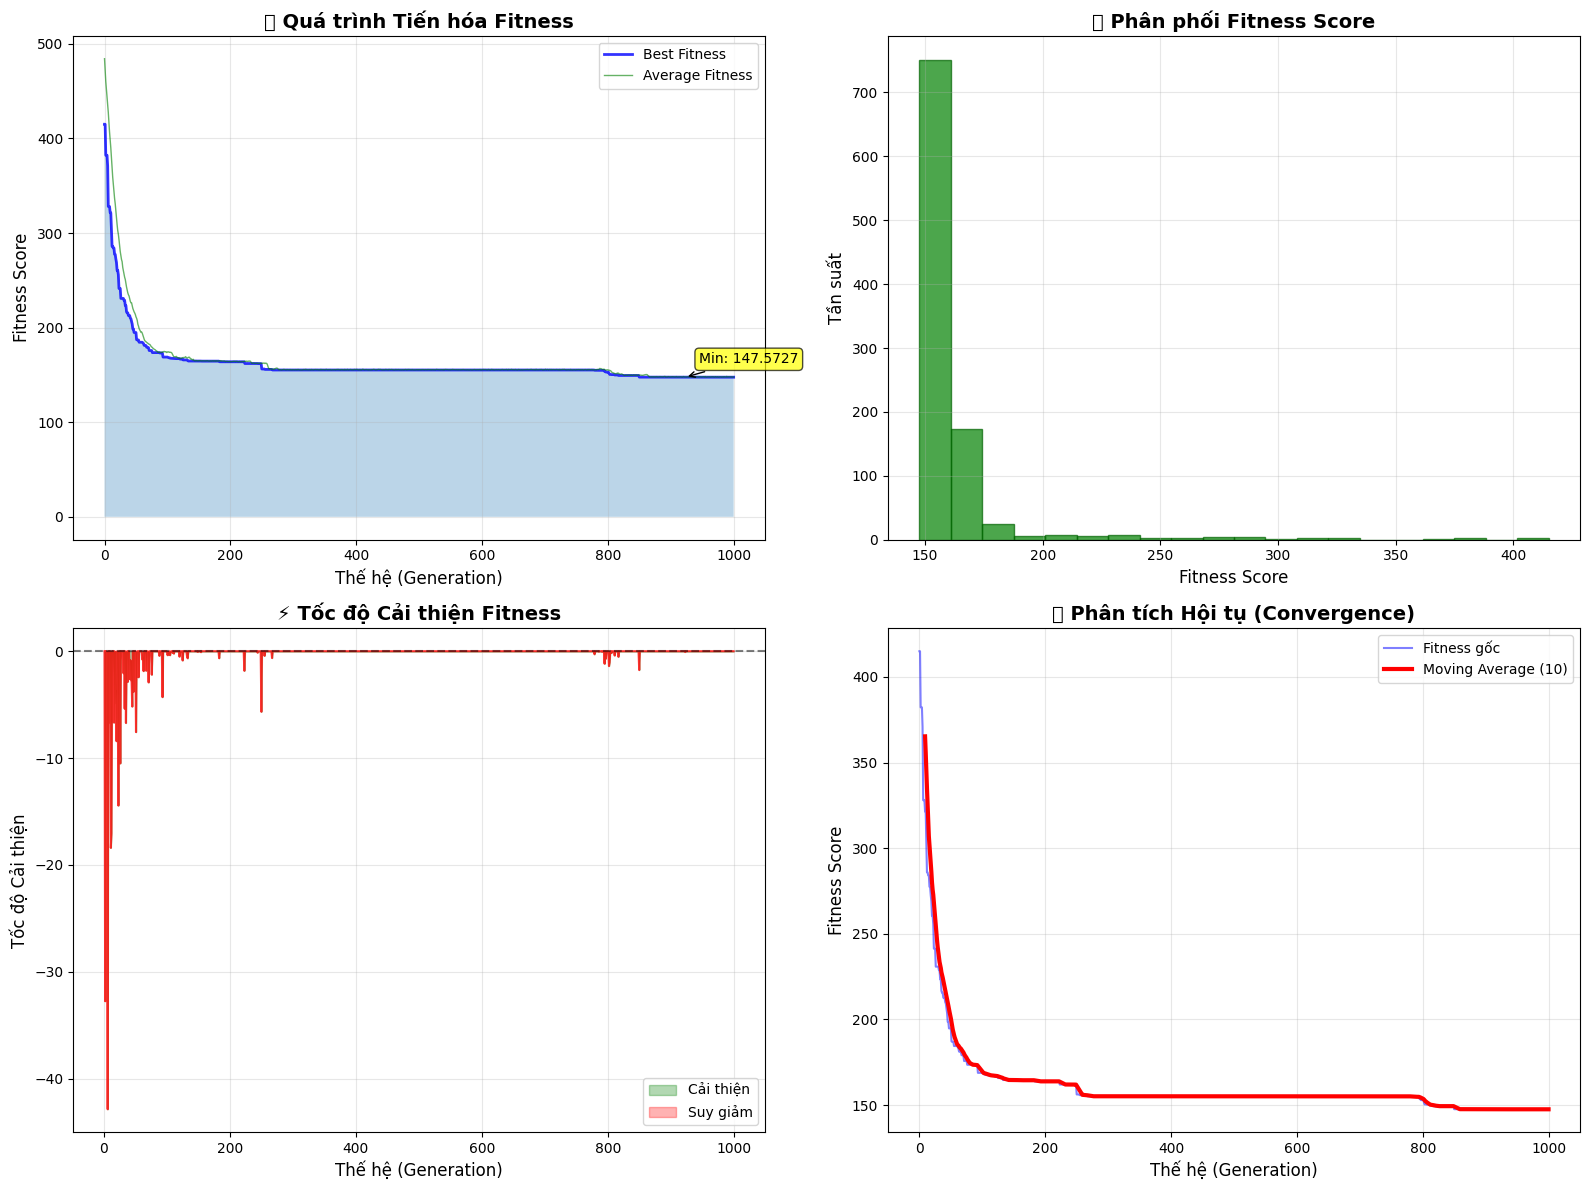


Thống kê quá trình tiến hóa:
Fitness cuối cùng: 147.572685
Fitness cao nhất: 414.967209
Fitness thấp nhất: 147.572685
Fitness trung bình: 161.669868
Độ lệch chuẩn: 27.887647
Tổng cải thiện: 267.394524
Tốc độ cải thiện trung bình: 0.267127/thế hệ


In [11]:
progress = ga.get_progress()

# Create a separate figure for saving
plt_save = plot_evolution_progress(
    progress["best_fitness_history"], 
    progress["avg_fitness_history"]
)
plot_path = os.path.join(static_dir, "fitness_evolution.png")
plt_save.savefig(plot_path)
plt_save.close()

# Create a new figure for the dashboard visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Biểu đồ 1: Tiến hóa Fitness qua các thế hệ
generations = range(len(progress["best_fitness_history"]))
ax1.plot(generations, progress["best_fitness_history"], 'b-', linewidth=2, alpha=0.8, label='Best Fitness')
ax1.plot(generations, progress["avg_fitness_history"], 'g-', linewidth=1, alpha=0.6, label='Average Fitness')
ax1.fill_between(generations, progress["best_fitness_history"], alpha=0.3)
ax1.set_xlabel('Thế hệ (Generation)', fontsize=12)
ax1.set_ylabel('Fitness Score', fontsize=12)
ax1.set_title('📈 Quá trình Tiến hóa Fitness', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Thêm chú thích cho các mốc quan trọng
if len(progress["best_fitness_history"]) > 10:
    min_fitness_idx = np.argmin(progress["best_fitness_history"])
    ax1.annotate(f'Min: {progress["best_fitness_history"][min_fitness_idx]:.4f}', 
                xy=(min_fitness_idx, progress["best_fitness_history"][min_fitness_idx]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Biểu đồ 2: Histogram phân phối Fitness
ax2.hist(progress["best_fitness_history"], bins=20, alpha=0.7, color='green', edgecolor='darkgreen')
ax2.set_xlabel('Fitness Score', fontsize=12)
ax2.set_ylabel('Tần suất', fontsize=12)
ax2.set_title('📊 Phân phối Fitness Score', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Biểu đồ 3: Tốc độ cải thiện (Improvement Rate)
if len(progress["best_fitness_history"]) > 1:
    improvement_rate = np.diff(progress["best_fitness_history"])
    ax3.plot(range(1, len(progress["best_fitness_history"])), improvement_rate, 'r-', alpha=0.8)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Thế hệ (Generation)', fontsize=12)
    ax3.set_ylabel('Tốc độ Cải thiện', fontsize=12)
    ax3.set_title('⚡ Tốc độ Cải thiện Fitness', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Tô màu vùng cải thiện và suy giảm
    ax3.fill_between(range(1, len(progress["best_fitness_history"])), improvement_rate, 0, 
                    where=(improvement_rate <= 0), color='green', alpha=0.3, label='Cải thiện')
    ax3.fill_between(range(1, len(progress["best_fitness_history"])), improvement_rate, 0, 
                    where=(improvement_rate > 0), color='red', alpha=0.3, label='Suy giảm')
    ax3.legend()

# Biểu đồ 4: Convergence Analysis
window_size = 10
if len(progress["best_fitness_history"]) > window_size:
    moving_avg = np.convolve(progress["best_fitness_history"], np.ones(window_size)/window_size, mode='valid')
    ax4.plot(generations, progress["best_fitness_history"], 'b-', alpha=0.5, label='Fitness gốc')
    ax4.plot(range(window_size-1, len(progress["best_fitness_history"])), moving_avg, 'r-', 
            linewidth=3, label=f'Moving Average ({window_size})')
    ax4.set_xlabel('Thế hệ (Generation)', fontsize=12)
    ax4.set_ylabel('Fitness Score', fontsize=12)
    ax4.set_title('🎯 Phân tích Hội tụ (Convergence)', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.plot(generations, progress["best_fitness_history"], 'b-', linewidth=2)
    ax4.set_title('🎯 Fitness Evolution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Thống kê chi tiết về quá trình tiến hóa
print("\nThống kê quá trình tiến hóa:")
print(f"Fitness cuối cùng: {progress['best_fitness_history'][-1]:.6f}")
print(f"Fitness cao nhất: {max(progress['best_fitness_history']):.6f}")
print(f"Fitness thấp nhất: {min(progress['best_fitness_history']):.6f}")
print(f"Fitness trung bình: {np.mean(progress['best_fitness_history']):.6f}")
print(f"Độ lệch chuẩn: {np.std(progress['best_fitness_history']):.6f}")

if len(progress["best_fitness_history"]) > 1:
    total_improvement = abs(progress["best_fitness_history"][-1] - progress["best_fitness_history"][0])
    improvement_rate = total_improvement / len(progress["best_fitness_history"])
    print(f"Tổng cải thiện: {total_improvement:.6f}")
    print(f"Tốc độ cải thiện trung bình: {improvement_rate:.6f}/thế hệ")

## Minh họa thuật toán

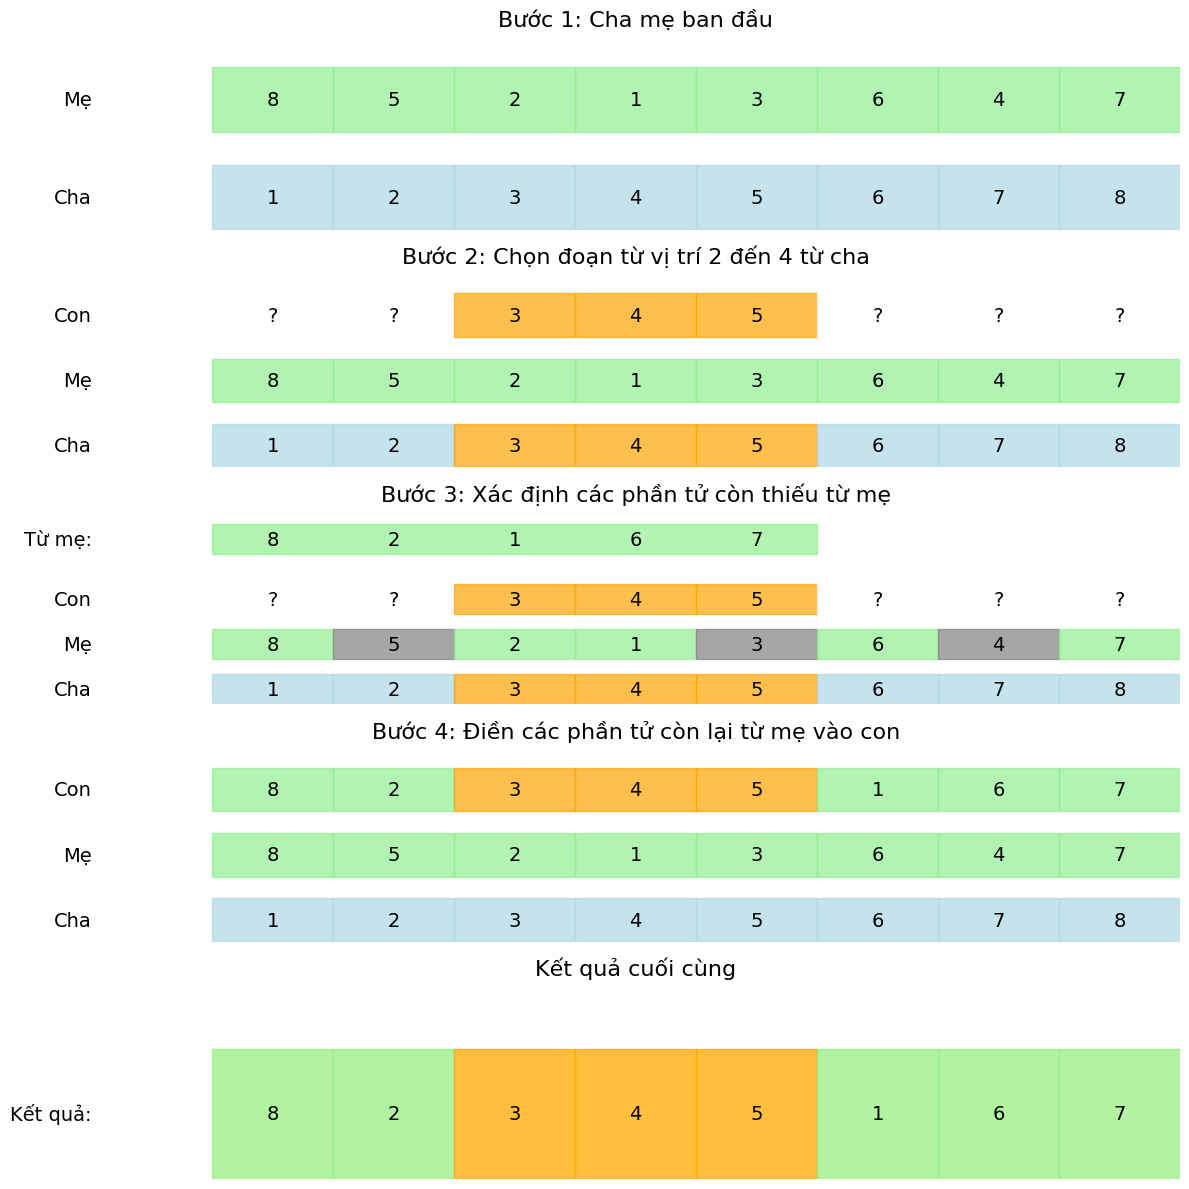

Cha:   [1, 2, 3, 4, 5, 6, 7, 8]
Mẹ:    [8, 5, 2, 1, 3, 6, 4, 7]
Con:   [8, 2, 3, 4, 5, 1, 6, 7]


In [3]:
parent1 = [1, 2, 3, 4, 5, 6, 7, 8]
parent2 = [8, 5, 2, 1, 3, 6, 4, 7]

result = visualize_order_crossover(parent1, parent2)
print(f"Cha:   {parent1}")
print(f"Mẹ:    {parent2}")
print(f"Con:   {result}")

c:\Users\rowan.nguyen\do_an_final\src\vrp\utils\utils.py:295: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, 0), 1, 1, fill=True,
c:\Users\rowan.nguyen\do_an_final\src\vrp\utils\utils.py:311: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, 0), 1, 1, fill=True,
c:\Users\rowan.nguyen\do_an_final\src\vrp\utils\utils.py:331: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, 0), 1, 1, fill=True,
c:\Users\rowan.nguyen\do_an_final\src\vrp\utils\utils.py:350: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, 1), 1, 1, fill=True,
c:\Users\rowan.nguyen\do_an_final\src\vrp\utils\utils.py:356: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.

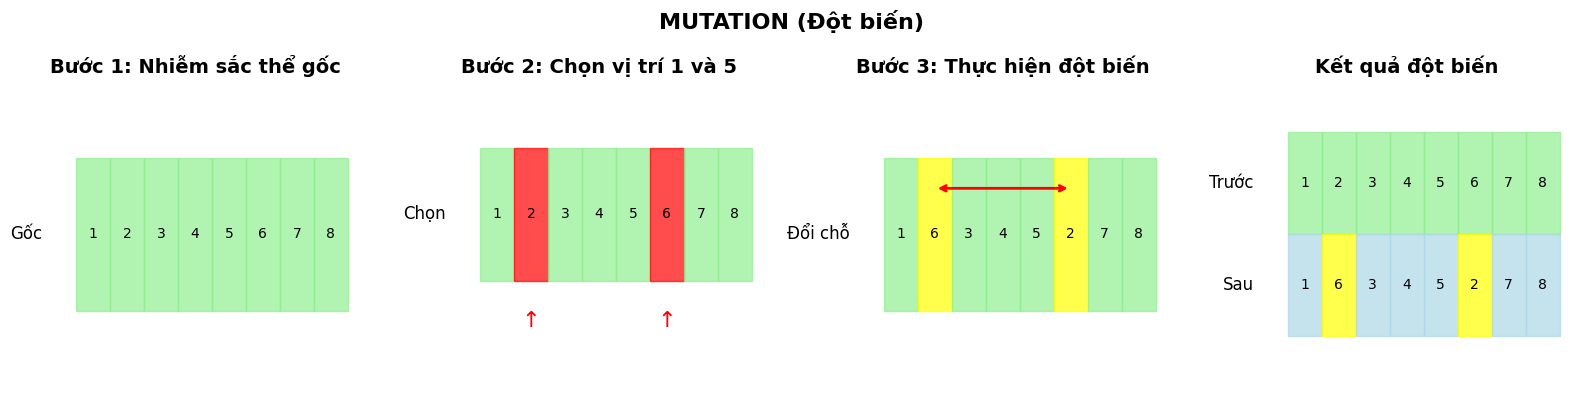

In [4]:
offspring1 = [1, 2, 3, 4, 5, 6, 7, 8]

a = visualize_Mutation(offspring1)